<a href="https://colab.research.google.com/github/cdurakci/nnet_ts_forecast_demos/blob/main/ZamanSerisi_BasitOrnek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Ders 1
Keras ile En Basit LSTM Tahmin Örneği

10, 20, 30, 40, 50, 60, 70, 80, 90 diye giden basit bir zaman serimiz olduğunu var sayalım. Tarih/Zaman indexi yok, en basit haliyle.

In [3]:
Zaman_Serisi = [10, 20, 30, 40, 50, 60, 70, 80, 90]

Bu zaman serisini, önceki 3 adıma bakıp (Input), 4.yü (Output) tahmin edilebilecek şekilde parçalara bölelim
ve Neural Networkü eğitebileceğimiz formatta veri seti oluşturalım,


```
yani input x
[10, 20 ,30] verip y = 40
[20 , 30, 40] verip y = 50
[30, 40, 50] verip y = 60
......
[60, 70 , 80] verip y= 90
şeklinde hareketli ortalama gibi 3'erli kayan bir veri seti haline çevirelim sonra da
[70, 80, 90] verip y = ? tahmin edelim

```
Bunu yapacak yardımcı fonksiyonu yazalım, ne olduğuna fonksiyonun içine takılmayalım fazla. Çünkü bir daha hiç gerek kalmayacak buna.



In [5]:
from numpy import array

def Dizi_Bolucu(dizi, Adim_Sayisi):
	X, y = list(), list()
	for i in range(len(dizi)):
		# find the end of this pattern
		end_ix = i + Adim_Sayisi
		# check if we are beyond the sequence
		if end_ix > len(dizi)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = dizi[i:end_ix], dizi[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# 3 Adıma bölelim
4.sıradaki değeri tahmin için Önceki 3 Adıma bakalım demiştik, adım sayısını tanımlayıp, dizi bölücü fonksiyonuna zaman serimizi ve adim sayimizi verip, zaman serimizi böldürüyoruz

In [15]:
# Adım Sayımızı Tanımlayalım
Adim_Sayisi = 3

# Zaman Serimizi 3'lü X Parçalarına ve 1 adet y parçasına Bölelim
X, y = Dizi_Bolucu(Zaman_Serisi, Adim_Sayisi)


X ve y 'nin içeriğine bakıp kontrol edelim istediğimiz gibi mi, 6 tane 3erli

In [12]:
X

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60],
       [50, 60, 70],
       [60, 70, 80]])

In [13]:
y

array([40, 50, 60, 70, 80, 90])

Evet, istediğimiz gibi 3erli gruplar halinde 6 sıra şekillenmiş.
Şimdi 3'erli veriyi 3 tane tekil veri olarak yeniden boyutlandıralım

Hani Klasik Neural Network Grafiği vardır, Giriş ve Hidden Layers

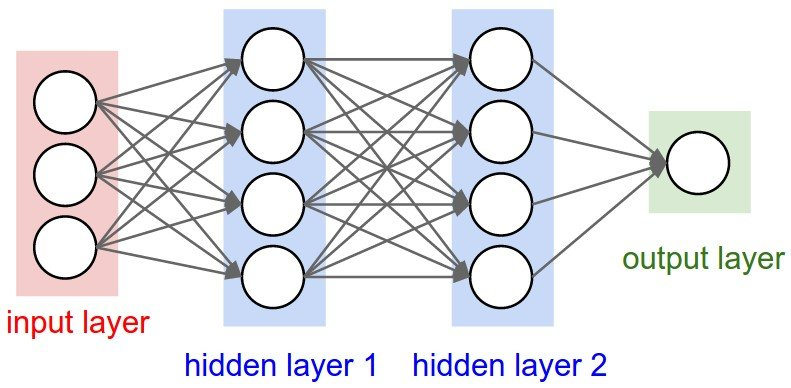


İşte o 3'lü inputu yapıcaz, verimiz tek boyutlu o yüzden 1'i seçiyoruz

In [18]:
Veri_Boyut_Sayisi = 1

X = X.reshape((X.shape[0], X.shape[1], Veri_Boyut_Sayisi))
X

array([[[10],
        [20],
        [30]],

       [[20],
        [30],
        [40]],

       [[30],
        [40],
        [50]],

       [[40],
        [50],
        [60]],

       [[50],
        [60],
        [70]],

       [[60],
        [70],
        [80]]])

Sıra Geldi Neural Network Modelimizi ve Katmanlarımızı Oluşturmaya

Zaman Serisi Tahmini için Klasik Model Mimarileri Gelişim Sırasıyla
*   MLP
*   RNN
*   LSTM
*   GRU' dur.

Biz daha gelişmiş olmasına rağmen daha basit ve Başarılı olan LSTM Modeli oluşturalım. Keras'ın içinde LSTM layerı zaten hazır olarak geliyor.

In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.utils import plot_model

#1. Model
 Yukardaki resimde 3 Input + 2x 4 boyutlu hidden layer ve 1 output vardı, burada 3 Input (birinci lstm layer'ına bağlı tanımlıyoruz input_shape parametresinde) 50 LSTM layerı, 2. 50 LSTM layerı ve Point Estimate yaptığımız Sonucu verecek 1 Boyutlu Dense Layer Output olarak tasarlıyoruz. (Dense full connected layer demek). Bu sayılara mesela 2x 50 neuronlu olmasına nasıl karar veriyoruz, Bunu afaki yaptık, çok büyük seçersek training çok zaman alır ve overfitting olabilir, çok düşük yaparsak öğrenmeyebilir ve accuracy düşük olabilir. Layer ve Neuron Sayısına Optimizasyonla karar vereceğimizi ilerde görücez.
 Activation Function, Deep Neural Networklerde her katmandan sonra activation function gerekir, detayına girmiyorum Linear, Sigmoid, Tanh vs gibi. Ne kullanacağınızı bilmiyorsanız ReLu kullanabilirsiniz, herzaman çalışır.
 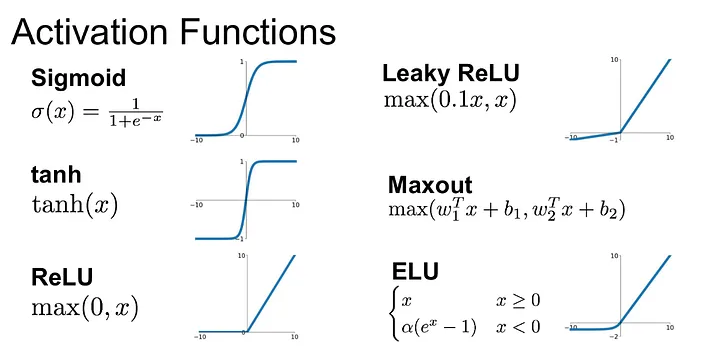

In [20]:
# Model Layerlarını Tanımlıyoruz

model = Sequential([ #Modeli Keras'ın Sequential API ile ard arda layerları tek tekgirerk yapacağımız için Sequential yaptık, zaman serisi ile alakalı değil.
    LSTM(50, activation='relu', return_sequences=True, input_shape=(Adim_Sayisi, Veri_Boyut_Sayisi)), #50 unit'lik LSTM Layerı, (3x1)'lik input'a bağlı
    LSTM(50, activation='relu'), #50 unit'lik LSTM Layerı
    Dense(1)
]) # Tanımı yaptık

# Modelimizin Bağlantıları yapılsın, burada başka parametreler de var, hyperparametreler ama kafa karışıklığı olmasın diye şimdilik gerek yok.
model.compile(optimizer='adam', loss='mse')
#Loss fonksiyonumuz mean squared error seçtik, başka birşey de seçebiliriz https://keras.io/api/losses/

Neural Network öğrenirken mutlaka Duymuşsunuzudur Gradient Decent, training esnasında neural network'ün iç ağırlıklarını optimize eder.
Stochastic Gradient Decent hızlı versiyonudur, biz Default olarak daha gelişmiş daha az RAM kullanan ve daha hızlı versiyonu Adam 'ı kullanıcaz, adam yerine SGD yazarak Stochastic Gradient Decent'te kullanabiliriz.

Modelimizin Özetini Görelim, Model Doğru oluşmuş mu istediğimiz gibi Neuron ve Layer Sayıları ile kontrol edelim

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Çizdirelim Şimdi

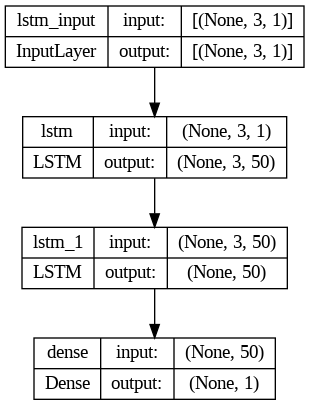

In [23]:
plot_model(model,show_shapes=True)

In [ ]:
# fit diyerek Modeli Eğitelim
model.fit(X, y, epochs=200, verbose=1) # 200 adım eğitsin, verbose = 1 diyerek ekrandan takip edelim, 0 dersek arkada sessiz çalışır.

Modelimiz Eğitildi, Şimdi hiç olmayan 3'lü yeni değerler verip modelimizle yeni tahmin yapalım
[100,110,120] verelim 130 vermesini bekleyelim.

In [36]:
# demonstrate prediction
x_input = array([100,110,120])
x_input = x_input.reshape((1, Adim_Sayisi , Veri_Boyut_Sayisi))
tahmin = model.predict(x_input, verbose=0)
print(tahmin.flatten())

[139.96303]


# 2. Model

1. Model için tahminimizi 130 beklerken 139 vererek 9 puan hatalı tahmin verdi, bunu düzeltmek için model layerları ile oynamamız gerekir, farklı mimariler denemek, farklı Neuron Sayıları, Farklı Layer Sayıları deneyerek bulmak gerekir.
Ayrıca Verimizi Scale etmemiz de gerekir, Nomralize Etmek, Standardize Etmek, MinMax, Robust vs. gibi. Şimdi bunlara girmeden, 2 x 50 yerine 1 x bidirectional çiftyönlü LSTM layerı ile deneyelim.
Burada model.add diyerek üsttekinden biraz farklı method ile layerlarımızı ekleyelim. Böyle de tanımlanabiliyor görmüş olalım diye böyle yaptık.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 100)               20800     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20901 (81.64 KB)
Trainable params: 20901 (81.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


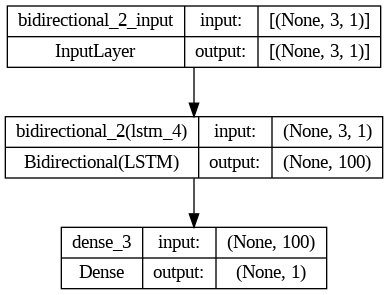

In [39]:
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(Adim_Sayisi, Veri_Boyut_Sayisi))),
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

print(model.summary())
plot_model(model,show_shapes=True)

In [ ]:
# fit diyerek Modeli Eğitelim
model.fit(X, y, epochs=200, verbose=1) # 200 adım eğitsin, verbose = 1 diyerek ekrandan takip edelim, 0 dersek arkada sessiz çalışır.

In [42]:
x_input = array([100,110,120])
x_input = x_input.reshape((1, Adim_Sayisi , Veri_Boyut_Sayisi))

tahmin = model.predict(x_input, verbose=0)
print(tahmin.flatten())

[136.24814]


Fark 9'dan 6'ya indi, tahmin başarısı arttı. Bu şekilde farklı Model Mimarileri deneyerek, HiperParametre Optimizasyonu, Regularization, Veriyi Scale etme vs ile başarı arttırılabilir.
Bu örnek en temel şekilde nasıl yapılır örneğiydi biz bu şekilde hiçbir zaman yapmayacağız.

Artık MLP, RNN, LSTM, GRU kullanılmıyor. Bu modelleri bütün Benchmarklarda geçebilen yeni Mimariler var, bunları Researcher'lar bulmuşlar, çeşitli yarışmalarda başarı sağlamışlar Akademik Makalelerini de yazmışlar.
Ben 2015'te MLP ve GBM ile çok deney yapmıştım XGboost Algoritması ilk çıktığında, o zaman Lag'lı hisse fiyatı veriyordunuz, 10 periyot 20 periyot 50, 100, 200 periyot öncesi ile, 5-10 boyutlu veri, başarı MLP'de %50, XGBoost'ta %60-65 civarı çıkıyordu ama çıkan sonuç teknik analiz deki SMA(20)'ye converge ediyordu. SMA20'nin üstü hep al sinyali, altı sat sinyali gibi. %40 hatayıda SMA20'ye yaklaşırken ve terse kırarken yapıyordu. O yüzden kullanılması anlamsızdı. Kalman Filtresi de SMA20 civarına yakınsar. Çok başarısı yoktu. RNN'de ise Konspet olarak Vanishing Gradient / EXploding Gradient problemi var o yüzden baştan çöp. LSTM iyidir, ama o da yetersiz.
Bütün bu mimarileri ve 2020 sonrası keşfedilen NBEATS, NHITS, DEEPAR, PatchTST, TimesNET gibi aynı zamanda Büyük Dil Modellerinde Kullanılan Transformer Mimarilerini de içeren hazır Zaman Serisi Tahminleme Paketleri var.

*  https://ts.gluon.ai/stable/getting_started/models.html

*  https://pytorch-forecasting.readthedocs.io/en/stable/models.html

gibi paketler var. Ama benim favorim, Nixtla'nın NeuralForecast paketi çünkü otomatik veri scaling'i yapabiliyor ve otomatik hiper parametre optimizasyonu yapabiliyor. Bu yönüyle çok pratik, rahat ve birçok gereksiz şeyi AI Researcher seviyesinde bilmenize gerek kalmadan rahatça yapabiliyorsunuz. Tüm modelleri aynı anda tek kod tabanında train/validation yapabiliyor.

*  https://nixtlaverse.nixtla.io/neuralforecast/index.html

Diğer Örneklerde artık bunu kullanacağız ve çok daha profesyonel çok daha başarılı SOTA modelleri eğiticez.

Şu blog post önemli, bunu okumanızı şiddetle tavsiye ederim, bundan sonraki adımda yapacaklarımızın ne olacağı için. Özellikle Model Kornolojisi ve Modern Mimariler.

https://medium.com/@ycwong.joe/a-brief-history-of-time-series-models-38455c2cd78d

ve bunu
https://archive.is/BoJ56

siz ekonometrik modelleri benden çok daha iyi biliyorsunuz, daha iyi anlarsınız.

